# EDINETのAPIを使用してみる
本書のゴール＝四半期報告書のpdfを取得する

以下のコンテンツではEDINET閲覧サイト（[url](https://disclosure2.edinet-fsa.go.jp/WEEE0030.aspx?bXVsPeWVhuiIueS4ieS6lSZjdGY9b2ZmJmZscz1vbiZscHI9b2ZmJnJwcj1vZmYmb3RoPW9mZiZwZnM9NiZ5ZXI9Jm1vbj0=)）から取得できる情報をもとにデータを加工して作成しています。本ページに記載されているコードの実行や取得したデータの利用についてはEDINETの利用規約を確認し理解した上で利用してください。また、Version2のAPIを使用する際はログイン認証＋APIキーの発行が必要になります。

※注意：使用時には必ず利用規約（[pdf](https://disclosure2dl.edinet-fsa.go.jp/guide/static/disclosure/download/ESE140191.pdf)・[web](https://disclosure2dl.edinet-fsa.go.jp/guide/static/submit/WZEK0030.html))を確認した上で常識の範囲内での使用にとどめてください。

In [1]:
import os
import time
import zipfile

import pandas as pd
import requests

API_ENDPOINT = "https://disclosure.edinet-fsa.go.jp/api/v2"  # v2を使用する


def save_csv(docID, type=5):
    """EDINETからデータを取得してフォルダに保存する

    Args:
        docID (str): DocID
    """
    assert type in [1, 2, 3, 4, 5], "typeの指定が間違っている"
    if type == 1:
        print(f"{docID}のXBRLデータを取得中")
    elif type == 2:
        print(f"{docID}のpdfデータを取得中")
    elif type in {3, 4}:
        print(f"{docID}のデータを取得中")
    elif type == 5:
        print(f"{docID}のcsvデータを取得中")
        time.sleep(5)

    r = requests.get(
        f"{API_ENDPOINT}/documents/{docID}",
        {
            "type": type,
            "Subscription-Key": os.environ.get("EDINET_API_KEY"),
        },
    )

    if r is None:
        print("データの取得に失敗しました。csvFlag==1かどうか確認してください。")
    else:
        os.makedirs(f"{docID}", exist_ok=True)
        temp_zip = "uuid_89FD71B5_CD7B_4833-B30D‗5AA5006097E2.zip"

        with open(temp_zip, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                f.write(chunk)

        with zipfile.ZipFile(temp_zip) as z:
            z.extractall(f"{docID}")

        os.remove(temp_zip)

### 書類取得API
csvデータをAPI経由で取得してzipファイルに保存します。

In [2]:
docID_dict = {
    "商船三井": "S100STH6",
    "日本郵船": "S100SS7P",
    "玉井商船株式会社": "S100STLS",
    "川崎汽船": "S100SRTI",
    "飯野海運": "S100SP9O",
}

for docID in docID_dict.values():
    save_csv(docID, type=5)

S100STH6のcsvデータを取得中
S100SS7Pのcsvデータを取得中
S100STLSのcsvデータを取得中
S100SRTIのcsvデータを取得中
S100SP9Oのcsvデータを取得中


### 取得したデータの確認

In [3]:
dfs = []

for companyName, docID in docID_dict.items():
    csv_savedir = os.path.join(docID, "XBRL_TO_CSV")
    filelist = [f for f in os.listdir(csv_savedir) if f.startswith("jpcrp")]
    if len(filelist) > 0:
        df = pd.read_csv(
            os.path.join(csv_savedir, filelist[0]), encoding="utf-16", sep="\t"
        )
        df["会社名"] = [companyName for _ in range(df.shape[0])]
        dfs.append(df)

all_data = pd.concat(dfs)
all_data.head()

,要素ID,項目名,コンテキストID,相対年度,連結・個別,期間・時点,ユニットID,単位,値,会社名
0,jpdei_cor:NumberOfSubmissionDEI,提出回数、DEI,FilingDateInstant,提出日時点,その他,時点,pure,NaN,1,商船三井
1,jpcrp_cor:NetSalesSummaryOfBusinessResults,売上高、経営指標等,Prior1YTDDuration,前年度同四半期累計期間,その他,期間,JPY,円,1257968000000,商船三井
2,jpcrp_cor:NetSalesSummaryOfBusinessResults,売上高、経営指標等,CurrentYTDDuration,当四半期累計期間,その他,期間,JPY,円,1218664000000,商船三井
3,jpcrp_cor:NetSalesSummaryOfBusinessResults,売上高、経営指標等,Prior1YearDuration,前期,その他,期間,JPY,円,1611984000000,商船三井
4,jpcrp_cor:OrdinaryIncomeLossSummaryOfBusinessR...,経常利益又は経常損失（△）、経営指標等,Prior1YTDDuration,前年度同四半期累計期間,その他,期間,JPY,円,739254000000,商船三井


#### 取得したデータを確認してみる

[EDINET タクソノミ の概要説明](https://www.fsa.go.jp/search/20221108/1b-1_GaiyoSetsumei.pdf)を見ながらデータのある項目を抽出してみます。

In [4]:
print(
    all_data.query(f"要素ID=='jpcrp_cor:NotesRegardingDividendTextBlock'")[["会社名", "値"]]
)

          会社名                                                  値
462      商船三井  １．配当金支払額（決議）株式の種類配当金の総額（百万円）１株当たり配当額（円）基準日効力発生...
463      商船三井  １．配当金支払額（決議）株式の種類配当金の総額（百万円）１株当たり配当額（円）基準日効力発生...
431      日本郵船  配当金支払額（決議）株式の種類配当金の総額（百万円）配当の原資１株当たり配当額（円）基準日効...
432      日本郵船  配当金支払額（決議）株式の種類配当金の総額（百万円）配当の原資１株当たり配当額（円）基準日効...
334  玉井商船株式会社  前第３四半期連結累計期間（自　2022年４月１日　至　2022年12月31日）１．配当金支払...
335  玉井商船株式会社  当第３四半期連結累計期間（自　2023年４月１日　至　2023年12月31日）１．配当金支払...
380      川崎汽船  １．配当金支払額（決議）株式の種類配当金の総額（百万円）１株当たり配当額（円）基準日効力発生...
382      川崎汽船  １．配当金支払額（決議）株式の種類配当金の総額（百万円）１株当たり配当額（円）基準日効力発生...
385      飯野海運  １　配当金支払額（決議）株式の種類配当金の総額（百万円）１株当たり配当額（円）基準日効力発生...
386      飯野海運  １　配当金支払額（決議）株式の種類配当金の総額（百万円）１株当たり配当額（円）基準日効力発生...


#### グラフを作る
１株当たり当期純利益又は当期純損失(いわゆるEPS)の変化を可視化して比較したいと思います。


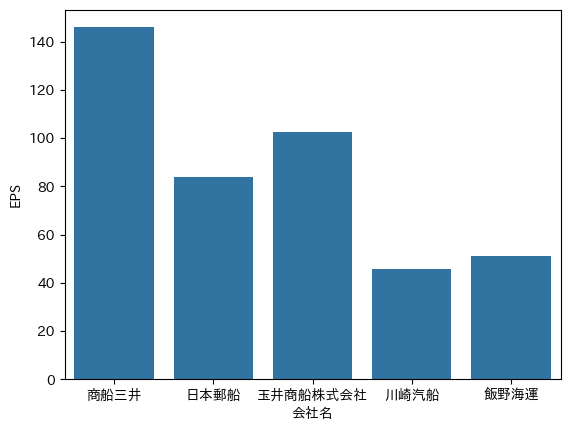

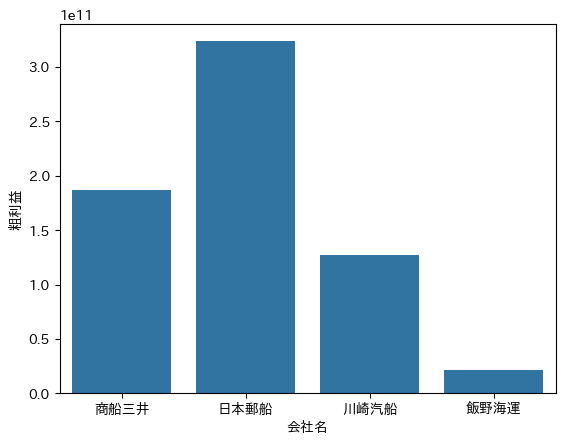

In [5]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


def compare_company_IR(data, contextId, elementId, elementJpName):
    plot_data = data.query(f"要素ID=='{elementId}' and コンテキストID=='{contextId}'").copy()
    plot_data[elementJpName] = pd.to_numeric(plot_data["値"])
    sns.barplot(data=plot_data, x="会社名", y=elementJpName)
    plt.ylabel(elementJpName)
    plt.show()


compare_company_IR(
    all_data,
    "CurrentQuarterDuration",
    "jpcrp_cor:BasicEarningsLossPerShareSummaryOfBusinessResults",
    "EPS",
)

compare_company_IR(all_data, "CurrentYTDDuration", "jppfs_cor:GrossProfit", "粗利益")

## XBRLファイルからデータを取得する

`pip install edinet-xbrl`にてライブラリをインストールし使用します。
参考文献：[EDINETのXBRL用のPythonライブラリを作った - Parser編](https://qiita.com/shoe116/items/dd362ad880f2b6baa96f)

コンテキストIDを指定することで指定した時期のデータを取得できます。以下の`__NUM__`には0~9の値が入ります（[ドキュメント](https://disclosure2dl.edinet-fsa.go.jp/guide/static/submit/download/ESE140119.pdf)）。


```
Prior__NUM__YearDuration
CurrentYearDuration
Prior__NUM__YearInstant
CurrentYearInstant
CurrentQuarterDuration
CurrentQuarterInstant
Prior__NUM__QuarterDuration
Prior__NUM__QuarterInstant
CurrentYTDDuration
Prior__NUM__YTDDuration
InterimDuration
InterimInstant
Prior__NUM__InterimDuration
Prior__NUM__InterimInstant
```

In [6]:
for docID in docID_dict.values():
    save_csv(docID, type=1)

S100STH6のXBRLデータを取得中
S100SS7PのXBRLデータを取得中
S100STLSのXBRLデータを取得中
S100SRTIのXBRLデータを取得中
S100SP9OのXBRLデータを取得中


In [7]:
from edinet_xbrl.edinet_xbrl_parser import EdinetXbrlParser

parser = EdinetXbrlParser()
edinet_xbrl_object = parser.parse_file(
    "S100QZLI/XBRL/PublicDoc/jpcrp030000-asr-001_E04236-000_2023-03-31_01_2023-06-20.xbrl"
)

key = "jppfs_cor:Assets"
context_ref = "Prior1YearInstant"
current_year_assets = edinet_xbrl_object.get_data_by_context_ref(
    key, context_ref
).get_value()
current_year_assets

c:\Users\nanja-win-ms\miniconda3\envs\py39\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


'2686701000000'

## 配当の推移
１株当たり配当額（`DividendPaidPerShareSummaryOfBusinessResults`）をプロットしてみます。

<BarContainer object of 5 artists>

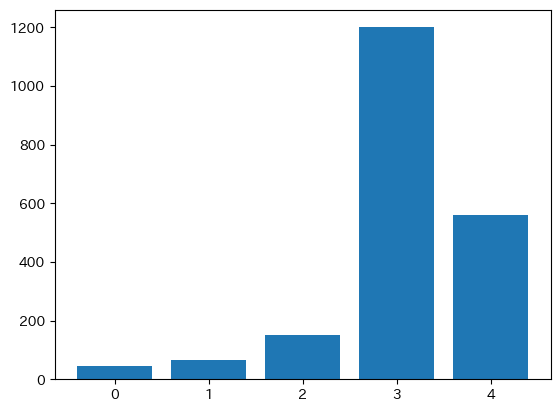

In [8]:
key = "jpcrp_cor:DividendPaidPerShareSummaryOfBusinessResults"
edinet_xbrl_object = parser.parse_file(
    r"S100QZLI\XBRL\PublicDoc\jpcrp030000-asr-001_E04236-000_2023-03-31_01_2023-06-20.xbrl"
)
interimDividendPaidPerShares = []
context_refs = [
    "Prior4YearDuration_NonConsolidatedMember",
    "Prior3YearDuration_NonConsolidatedMember",
    "Prior2YearDuration_NonConsolidatedMember",
    "Prior1YearDuration_NonConsolidatedMember",
    "CurrentYearDuration_NonConsolidatedMember",
]

for context_ref in context_refs:
    current_year_assets = edinet_xbrl_object.get_data_by_context_ref(
        key, context_ref
    ).get_value()
    interimDividendPaidPerShares.append(pd.to_numeric(current_year_assets))


plt.bar(
    [i for i in range(len(interimDividendPaidPerShares))], interimDividendPaidPerShares
)